In [1]:
import math

from typing import List, Optional, Union, Tuple # Python >= 3.5
from collections import Counter # Python >= 3.1

from matplotlib import pyplot as plt # please make sure you have matplotlib installed (pip install matplotlib)
import numpy as np # please make sure you have numpy installed (pip install numpy)
import pandas as pd # please make sure you have pandas installed (pip install pandas)

# Exercise 1

---

#### **Exercise 1.1**

In this exercise we are going to work with characters in an alphabet.
Assume, you have a string `cdd`, then the empirical probability $p(`c`)=\frac{1}{3}$ and $p(`d`)=\frac{2}{3}$.
Hence, $p$ is a probability distribution over an alphabet.

Assume you only have two characters in an alphabet, 'a' and 'b'. 


* **What does the probability of 'a' and 'b' have to be in order for the entropy to be maximal?**
* **What is the maximum value of the entropy in this case?**
* **Intuitively, why is the entropy maximum for the value you found?** (You can calculate it on paper or write it in Python, you will need it later anyway)

*** Your answers ***

#### **Exercise 1.2**

Still assume that your alphabet consists of only two characters, 'a' and 'b'.
For values $p(`a`) = 0.01, 0.02, \ldots, 0.99$, plot the entropy of your alphabet ($x$-axis: $p(`a`)$, $y$-axis: Entropy in bits).
Your plot should contain only one line.

If you don't know how to plot with Matplotlib, there is a really short crash course in the next cell.

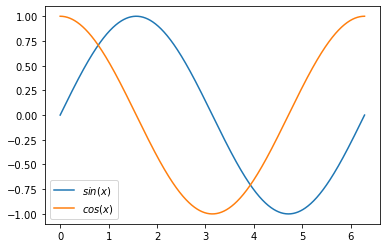

In [2]:
x = np.linspace(0, 2*math.pi, 1000) # generate 1000 x-values between 0 (inclusive) and 2 pi (inclusive)
y1 = np.sin(x) # compute sine of x elementwise
y2 = np.cos(x) # compute sine of x elementwise
plt.plot(x,y1,label=r"$sin(x)$") # plot values with label
plt.plot(x,y2,label=r"$cos(x)$") # plot values with label
plt.legend() # show legend
# you might need to run plt.show() if nothing shows up

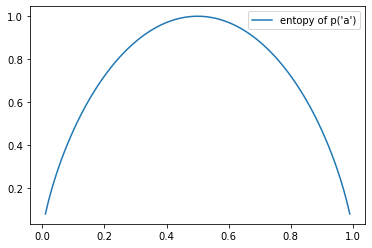

In [3]:
# ******************
# * Your code here *
# ******************
N = 99
pa=np.linspace(0.01,0.99,N)

def H(i):
    return pa[i]*np.log2(1/pa[i]) + (1-pa[i])*np.log2(1/(1-pa[i]))

ans=[]
for i in range(N):
    ans.append(H(i))

plt.plot(pa,ans,label=r"entopy of p('a')")
plt.legend()


#### **Exercise 1.3**

A measure that is related to Entropy is the *Gini Impurity* which is defined by
$$
    G(p) = 1-\sum_{x\in\mathcal{X}}p(x)^2
$$

Extend the plot from Exercise 1.2, such that you also plot the Gini Impurity for the different values of $p(`a`)$. What do you notice?

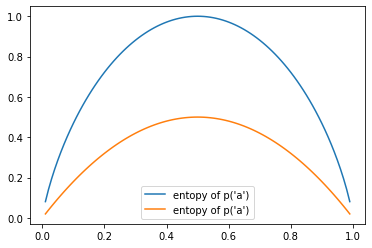

In [4]:
# ******************
# * Your code here *
# ******************
N = 99
pa=np.linspace(0.01,0.99,N)

def H(i):
    return pa[i]*np.log2(1/pa[i]) + (1-pa[i])*np.log2(1/(1-pa[i]))
def G(i):
    return 1 - (pa[i]*pa[i] + (1-pa[i])*(1-pa[i]))

ans=[]
ans2 = []
for i in range(N):
    ans.append(H(i))
    ans2.append(G(i))

plt.plot(pa,ans,label=r"entopy of p('a')")
plt.plot(pa,ans2,label=r"entopy of p('a')")
plt.legend()

# Exercise 2

---

In the lecture, we talked about a coding scheme with certain information-theoretic properties (Huffman coding). Below you find an implementation of Huffman coding using two classes, `CharacterTree` and `HuffmanCode`. The implementation of `HuffmanCode` might be interesting for you if you need to code a tree-structure in a later assignment. The code for `CharacterTree` is in the file `charactertree.py`.

In this exercise, we will work with the Huffman code. Below is a list of methods of this class.

* `Huffman(text)`: builds a code tree based on some string `text`.
* `unique_characters() -> List[str]`: returns a list of unique characters in the text
* `character_code(character: str) -> str`: returns the binary code (as a string) for a character in the code tree. If the character was not in the `text` the tree was built on, an `AttributeError` will be thrown.
* `character_probability(character: str) -> float`: returns the probability for a character in the code tree. If the character was not in the `text` the tree was built on, an `AttributeError` will be thrown.
* `string_code(string: str) -> str`: calls `character_code` for each character in the code and concatenates the codes to give an enconding of an entire string.
* `decode(code: str) -> str`: Decodes an encoded string. The code can be the code for one character or for an entire string.
* `entropy() -> float`: Returns the entropy of the code (***not yet implemented***)

In [5]:
from charactertree import CharacterTree

class HuffmanCode:
    def __init__(self, text: str):
        """
        :param text: the text should be a string
        """
        self.text = text
        self._compute_code_tree()

    def unique_characters(self) -> List[str]:
        """
        :return: a list of unique characters in the text
        """
        return list(set(self.text))

    def _compute_code_tree(self):
        """
        Compute the code tree for the given text
        
        :return: nothing but set attribute below
        """
        # use a Counter dictionary for convenience (https://docs.python.org/3/library/collections.html#collections.Counter)
        counter = Counter(self.text)
        # count of all characters (len(self.text) would give the same)
        total_character_count = sum(list(counter.values()))
        # make list of tuples of format (character, count)
        sorted_counter_item_list = list(counter.items())
        # build one-element tree for each of the unique words, initialized with their probability (character_count i[1] / total_count)
        priority_queue = [CharacterTree(probability=i[1] / total_character_count, character=i[0]) for i in
                          sorted_counter_item_list]
        # while our tree is not fully there yet (more than one element in the "queue")
        while len(priority_queue) > 1:
            # re-order priority queue according to new probabilities, lowest probability first
            priority_queue = sorted(priority_queue, key=lambda e: e.probability)
            # take first two elements from the "queue"
            first, second = priority_queue[:2]
            # build new tree with first element as left child and second element as right child
            subtree = CharacterTree(probability=first.probability + second.probability, left_child=first,
                                    right_child=second)
            # add new subtree to priority_queue (without the first two elements that are already in subtree)
            priority_queue = [subtree] + priority_queue[2:]
        # code tree is the first element once there is only one element left in the queue
        self.code_tree = priority_queue[0]

    @staticmethod
    def _character_code(tree: CharacterTree, character: str, current_code: str, return_probability=False) -> Optional[
        Union[str, Tuple[str, float]]]:
        """
        Find the code for a word in the tree.

        :param tree: the tree to search in
        :param character: the character for which the code should be returned
        :param current_code: the current code we already have (because this uses recursion)
        :param return_probability: whether we should also return the probability
        :return: either None if the character was not found, the code, or the code and the probability if return_probability is set to True
        """
        # go deeper if we are not in a leaf
        if tree.character is None:
            # recursively check the left subtree
            code = HuffmanCode._character_code(tree.left_child, character, current_code + "0",
                                               return_probability=return_probability)
            if code is None:
                # recursively check the right subtree if nothing found in the left subtree
                code = HuffmanCode._character_code(tree.right_child, character, current_code + "1",
                                                   return_probability=return_probability)
            return code
        # else return the code now, exit condition
        else:
            if tree.character == character:
                return current_code if not return_probability else (current_code, tree.probability)
            return None

    def character_code(self, character: str) -> str:
        """
        Find the code for a character in the tree. Throws an exception if the character is not in the tree.

        :param character: the character to find the code for
        :return: the code for the character
        """
        code = HuffmanCode._character_code(self.code_tree, character, "")
        if code is None:
            raise AttributeError(f"Character '{character}' is not part of the code tree.")
        return code

    def character_probability(self, character: str) -> float:
        """
        Find the probability of a character in the tree

        :param character: the character to find the probability for
        :return: the probability of the character
        """
        code_proba = HuffmanCode._character_code(self.code_tree, character, "", return_probability=True)
        if code_proba is None:
            raise AttributeError("Character is not part of the code tree")
        return code_proba[1]

    def string_code(self, string: str) -> str:
        """
        Find the code for a string in the tree.

        :param string: string as a list of
        :return: the code for the sentence
        """
        return "".join([self.character_code(w) for w in string])

    def decode(self, code: str) -> str:
        """
        Decode a coded character or string.

        :param code: the code to decode
        :return: the decoded string
        """
        # a function for the recursion
        def _decode(remaining_code: str, tree: CharacterTree):
            if tree.is_leaf():
                return remaining_code, tree.character
            else:
                next_char_zero = remaining_code[0] == "0"
                return _decode(remaining_code[1:],
                               tree.left_child if next_char_zero else tree.right_child)

        # start with the whole code
        remaining_code = code
        # store a list of already decoded words
        decode = []
        # while there is code left
        while len(remaining_code) > 0:
            # get the remaining code and the code for the current word
            rem_code, word_decode = _decode(remaining_code, self.code_tree)
            decode.append(word_decode)
            remaining_code = rem_code
        return "".join(decode)

    def entropy(self) -> float:
        """
        The entropy of the alphabet.

        :return: the entropy of the alphabet.
        """
        # ***************
        # TODO: your code
        # ***************
        #chars = self.unique_characters()
        
        #s = self.character_probability("L")
        entropy = -sum(self.character_probability(c) * np.log2(self.character_probability(c)) for c in self.unique_characters())
        return entropy

    def __str__(self):
        return self.code_tree.__str__()

#### Exercise 2.1

In the class `HuffmanCode`, there is a method `entropy` that returns the entropy of the encoded alphabet **in bits**.

Implement this method and compute the entropy of the following three strings using `HuffmanCode(string1).entropy()`, etc. Note that in this exercise we work with characters not with words as in the lecture.

In [6]:
string1 = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua." # Expected entropy: ~4.027
string2 = "Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat." # Expected entropy: ~4.042
string3 = "Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur." # Expected entropy: ~3.905

In [7]:
print(f"string1: {HuffmanCode(string1).entropy():.3f} (expected: 4.027)")
print(f"string2: {HuffmanCode(string2).entropy():.3f} (expected: 4.042)")
print(f"string3: {HuffmanCode(string3).entropy():.3f} (expected: 3.905)")

string1: 4.027 (expected: 4.027)
string2: 4.042 (expected: 4.042)
string3: 3.905 (expected: 3.905)


#### Exercise 2.2

Considering the alphabet of `string1`, what would be the maximum entropy a text with this alphabet could achieve? Why is this value larger than in Exercise 1? Feel free to find the answer by Python code.

*** Your answer ***

In [8]:
nbr=len(HuffmanCode(string1).unique_characters())
H=-(1/nbr*np.log2(1/nbr))*nbr
print(H)

4.392317422778761


#### Exercise 2.3

Solve exercise 1.1 by encoding a string consisting of the characters 'a' and 'b' such that the entropy is maximum.

* **How many such strings exist and what properties do they have?**
* **How would a string $s$ look like such that the entropy of $s$ goes to zero?**
* **In the lectures we talked about the entropy of a probability distribution whereas now we talk about strings. How are these things related?**

*** Your answers ***

In [9]:
string_ab="ab"

#### Exercise 2.4

We provide two text files, `lotr_en.txt` and `lotr_de.txt`, that contain text of 'Lord of the Rings (The Fellowship of the Ring)' in English and German respectively. You can create the `HuffmanCode` for both of them as follows: 

In [10]:
code_lotr_en = HuffmanCode(open("lotr_en.txt", encoding="utf-8").read())
code_lotr_de = HuffmanCode(open("lotr_de.txt", encoding="utf-8").read())

There is one other text file, `test.txt` that contains some other text. Assume we had to encode the text in `test.txt` with the code `code_lotr_en` or `code_lotr_de`. Please make sure to open the file using the UTF-8 encoding `open('test.txt', encoding='utf-8')` as otherwise you can get different values depending on your system's default encoding.

* **Without considering `test.txt` for the moment, which language seems to have the lower entropy?**
* **Measure the cross-entropy to answer the question whether it is more efficient to encode `test.txt` with the English or the German code.**
* **Why do you think the code you found in the answer to the previous question is better to use?**
* **What would be the best way to encode the text in `test.txt`? Intuitively, why can't the cross-entropy be negative?**
* **How could you easily compute the Kullback-Leibler divergence based on what you already did now?**

*** Your answers ***

In [11]:
# *****************
# *** Your code ***
# *****************
print(code_lotr_en.entropy())
print(code_lotr_de.entropy())
def crossH(hcode1, hcode2):
    xs = hcode1.unique_characters()
    H = 0
    for x in xs:
        try:
            q = hcode2.character_probability(x)
        except:
            q = 0
        p = hcode1.character_probability(x)
        H = H + q * np.log2(1/p)
    return H

print(crossH(code_lotr_en, code_lotr_de))
print(crossH(code_lotr_de, code_lotr_en))
#print(cross(code_lotr_de))

4.325265087324359
4.5794561990025375
4.700800517661474
4.558146221047277


# Exercise 3

---

In the next exercise, we will work with joint probability distributions. For this purpose, we use the Kaggle Titanic dataset which consists of records of survivors and non-survivors of the Titanic disaster. For this exercise, we will be only interested in some of the attributes, `Survived` and `Sex`.

In [12]:
titanic = pd.read_csv("titanic.csv")
titanic

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
882,0,2,Rev. Juozas Montvila,male,27.0,0,0,13.0000
883,1,1,Miss. Margaret Edith Graham,female,19.0,0,0,30.0000
884,0,3,Miss. Catherine Helen Johnston,female,7.0,1,2,23.4500
885,1,1,Mr. Karl Howell Behr,male,26.0,0,0,30.0000


As an example, we can compute the probability of a passenger being female or being female and in the third class as follows

In [13]:
p_female =  len(titanic.loc[(titanic['Sex'] == "female")]) / len(titanic)

p_female_and_third_class = len(titanic.loc[(titanic['Sex'] == "female") & (titanic['Pclass'] == 3)]) / len(titanic)
print(f"Probability of a female passenger: {p_female:.3f}")
print(f"Probability of a female passenger and in third class: {p_female_and_third_class:.3f}")

Probability of a female passenger: 0.354
Probability of a female passenger and in third class: 0.162


The following table gives you the joint a marginal probabilities for the random variables we consider.

| $S$ / $V$ | dead | alive | P($S$) |
| --------- | ---- | ----- | ------ |
| **female** | 0.091 | 0.262 | 0.354 |
| **male** | 0.523 | 0.122 | 0.646 |
| **P($V$)** | 0.6144 | 0.385 | 1 |

#### Exercise 3.1

* **Compute $H(S)$. There are already some variables defined that might be helpful, but you might need more.**
* **Consider $H(S)$. Is this a high or a low entropy? For what distribution would the uncertainty be maximal/minimal (with which value)?**

In [14]:
p_female =  len(titanic.loc[(titanic['Sex'] == "female")]) / len(titanic)
p_dead = len(titanic.loc[(titanic['Survived'] == 0)]) / len(titanic)

p_female_and_dead = len(titanic.loc[(titanic['Sex'] == "female") & (titanic['Survived'] == 0)]) / len(titanic)
p_male_and_alive = len(titanic.loc[(titanic['Sex'] == "male") & (titanic['Survived'] == 1)]) / len(titanic)
# *****************
# *** Your code ***
# *****************
entropy_sex = p_female*np.log2(1/p_female) + (1-p_female)*np.log2(1/(1-p_female))


print(f"H(S)={entropy_sex:.3f}")

H(S)=0.938


#### Exercise 3.2

Now, let further $V$ the random variable for a passenger's vitality, distributed according to the empirical distribution in our dataset. You can solve this exercise by coding (using the variables defined above) or with a calculator.

* **What is $H(V)$?**
* **What is $H(S|V)$?**
* **What is the mutual information $I(S; V)$?**
* **Does knowing $S$ reduce the uncertainty about $V$?**


In [15]:
# *****************
# *** Your code ***
# *****************
p_female =  len(titanic.loc[(titanic['Sex'] == "female")]) / len(titanic)
p_male = 1 - p_female

p_female_and_survive = len(titanic.loc[(titanic['Sex'] == "female") & (titanic['Survived'] == 1)]) / len(titanic)
p_male_and_survive = len(titanic.loc[(titanic['Sex'] == "male") & (titanic['Survived'] == 1)]) / len(titanic)

HV = p_female_and_survive*np.log2(1/p_female_and_survive) + p_male_and_survive*np.log2(1/p_male_and_survive)
print(HV)

HSV = p_female_and_survive*np.log2(1/p_female) + p_male_and_survive*np.log2(1/p_male)
print(HSV)

ISV = entropy_sex - HSV
print(ISV)


0.8782940445838011
0.4710112641766766
0.466580443281459


#### Exercise 3.3

**Assume $S$ and $V$ are marginally still distributed according to the empirical distribution in our dataset, i.e., the bottom row and the right column in the table above stay as they are.**
* **How must the joint probabilities look for $I(S; V)$ to be maximal?**
* **What would be the maximum value of $I(S; V)$?**
 * **What would the joint entropy be in that case?**

In [18]:
# so the matrix would be row1: 0.354  0      0.354
#                        row2: 0      0.646  0.646
#                        row3: 0.646  0.354  1
jointH=-(0.354*np.log2(0.354)+0.646*np.log2(0.646))
jointH

0.9375897508004305

In [ ]:
# I will increase for the more elements which is contained in both S and V. To maximize I we need to be the same. If they are independent then I is 0.

# I is I(S;V) = H(S) - H(S|V), in this case the H(S|V) term is 0, thus max value is H(S).
# Joint probability can be writen as H(S, V) = H(S) + H(V|S)